<a href="https://colab.research.google.com/github/hc0rd31r0/Bootcamp_Data_Science/blob/main/modulo-05/Bootcamp_DS_modulo5_aulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Módulo 5 - Modelos, métricas e validações em Machine Learning
---
##### *Material da aula, desafios no notebook Bootcamp_DS_modulo5-desafios.ipynb*

#Aula 01 - Workflow de Machine Learning



## Preparando dados

In [1]:
import pandas as pd
import numpy as np

# dados_raw = pd.read_excel('https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/dados/sirio-libanes/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
dados_raw = pd.read_excel('https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
dados = dados_raw.copy()
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [2]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [3]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [4]:
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

# Correto
# dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window).reset_index(drop=True)
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [6]:
np.random.seed(73246)

x_columns = dados.describe().columns
y = dados_limpos['ICU']
x = dados_limpos[x_columns].drop(['ICU'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [7]:
# modelo = LogisticRegression() # Assim da msg de Warning
# /usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
# STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
# Increase the number of iterations (max_iter) or scale the data as shown in:

modelo = LogisticRegression(max_iter=2000)
modelo.fit(x_train, y_train)

y_previsto = modelo.predict(x_test)
accuracy_score(y_test, y_previsto)

0.7045454545454546

## Coluna AGE_PERCENTIL e WINDOW

Vamos adicionar a coluna AGE_PERCENTIL aos nosso X, transformando esse valor em uma variável categórica.

A coluna ```WINDOW``` não precisa fazer parte pois na seleção dos dados nós fixamos com sendo a primeira janela.

In [8]:
for coluna in dados.columns:
  if coluna not in x_columns:
    print(coluna)

AGE_PERCENTIL
WINDOW


In [9]:
# dados_limpos.drop(['PATIENT_VISIT_IDENTIFIER','WINDOW'], axis=1, inplace=True)
# dados_limpos.drop(['WINDOW'], axis=1, inplace=True)
# método da aula
dados_limpos.AGE_PERCENTIL.astype("category").cat.codes

PATIENT_VISIT_IDENTIFIER      
0                         0       5
2                         10      0
3                         15      3
4                         20      0
5                         25      0
                                 ..
380                       1900    3
381                       1905    9
382                       1910    4
383                       1915    3
384                       1920    4
Length: 352, dtype: int8

In [10]:
# dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'].str.replace('Above 9','10').str.extract(r'(.+?)th')
# dados_limpos = dados_limpos.astype({'AGE_PERCENTIL': 'float'})
# dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'] / 10
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes

In [11]:
np.random.seed(73246)

x_columns = dados.columns  # Alterando de describe().columns para apenas columns
y = dados_limpos['ICU']
x = dados_limpos[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo_dummy = DummyClassifier()
modelo_dummy.fit(x_train, y_train)

y_prediction = modelo_dummy.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [12]:
# modelo_logreg = LogisticRegression(solver='liblinear', max_iter=2000 )
modelo_logreg = LogisticRegression(max_iter=2000)
modelo_logreg.fit(x_train, y_train)

y_previsto = modelo_logreg.predict(x_test)
accuracy_score(y_test, y_previsto)

0.6818181818181818

In [13]:
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

##Desafios

###**Desafio 01**

Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método.

---

Nesta aula:

* Qual é um possível Workflow em um projeto de Data Science;
* Realizar uma transformação de dados em dados categóricos;
* Aumentar o número de iterações da regressão logística para convergir.
---
---

#Aula 02 - Métricas de Avaliação


https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier


In [14]:
from sklearn.tree import DecisionTreeClassifier

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)

accuracy_score(y_test, predicao_arvore)

0.6590909090909091

##Métrica Acurácia
No modelo de Regressão Logística o valor foi de 0.6818
No modelo de Árvore de Decisão o valor foi 0.6590, então
podemos concluir que a Regressão Logística é o melhor modelo?

Mas, o que é a acurácia? É tudo o que aceitei de todo o meu Universo de dados. O que está correto de todos os meus dados.

Mas qual classe ele está acertando mais? 0, não internou ou 1, internou.

A acurária não mostra isso! Na imagem abaixo temos a matriz de confusão, e a acurácia é calculada nos valores que acertamos, ou seja, (0,0) e (1,1).

##Matriz de Confusão  

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

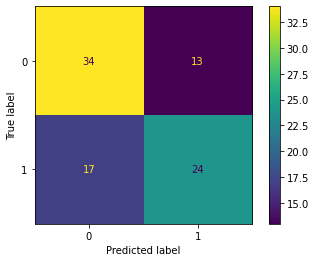

In [15]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(modelo_arvore, x_test, y_test)

* VP - Verdadeiro Positivo = 24
* VN - Verdadeiro Negativo = 34
* FP - Falso Positivo = 13
* FN - Falso Negativo = 17

True Label / Predicted label

Coluna 1 | Coluna 2
--- | ---
(0,0) = Verdadeiro Negativo | (1,0) = Falso Positivo
(0,1) = Falso Negativo | (1,1) = Verdadeiro Positivo

* VP - Modelo apontou Sim (1) para internar e realmente internou (1)  $ \bigwedge $ Salvamos uma vida
* VN - Modelo apontou Não (0) para internar e realmente não internou (0)  Sabia que estava certo!
* FP - Modelo apontou Sim (1) para internar e não internou (0)   ufa! Paciente passa bem
* FN - Modelo apontou Não (0) para internar e internou (1) $ \bigvee $  putz! Desculpe!


In [16]:
VP = 24
VN = 34
FP = 13
FN = 17

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



In [18]:
# precision
VP / (VP + FP)

0.6486486486486487

### **Métrica 'Precision'**

De todas as minhas classificações positivas, quantas são realmente positivas.

Vamos olhar mais para a precision quando o Falso Positivo for mais prejudicial que um Falso Negativo.
1. Exemplo: Um investimento que o modelo aponta como bom e se perde dinheiro (prejuízo) nesse caso devemos melhorar a precision para não ter perdas. Isso que interessa, então, nas comparações dos modelos essa métrica deve ter mais peso.
2. Exemplo do projeto: que o modelo indica que o paciente vai precisar de uma UTI, e não utiliza! Nesse caso a precision pode ter um valor ruim mas que ainda assim é um bom resultado.

In [19]:
# recall
VP / (VP + FN)

0.5853658536585366

### **Métrica 'Recall'**

De todas as classes positivas, quantas eu realmente **classifiquei corretamente**.

Quando o **Falso Negativo** é muito pior (prejudicial) que o *Falso Positivo* 

Exemplo do projeto: o modelo indica que o paciente NÃO precisa de UTI, vai para casa e logo após piora e precisa de UTI! Isso é muito ruim para o modelo, tendo um peso maior para esse caso.

### **f1-score**
f1-score = 2*((precision * recall) / (precision + recall)

Média harmônica entre *precision* e *recall*, sempre vai "direcionar" para o menor valor.

Mas por que média harmônica?
É a média que nos dá um alerta que de alguma das métricas está muito baixo.
Utiliza-se a média harmônica para tornar a métrica sensível a desproporções das taxas.

https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107


In [20]:
# teste 1 => p=0.5 e r=0.5 -> f1=0.5
# teste 2 => p=1.0 e r=0.5 -> f1=0.666666
p = 1.0
# teste 3 => p=1.0 e r=0.3   -> f1=0.4615384615384615
# teste 4 => p=1.0 e r=0.001 -> f1=0.0019980019980019984
r = 0.001
f1 = 2 * (p * r) / (p + r)
print( f1 )

0.0019980019980019984


O caso que estamos trabalho são os casos de COVID, a gente tem o problema do stress no sistema de Saúde. Imagine Recall muito Alto e Precision Baixo,
estou recuperando todas aquela pessoas que estão doentes, só que se meu modelo está classificando todos como 1 (viciado), não vai ter leito de UTI.

É necessário uma métrica que possa separar bem as classes (pessoas doente das não doentes), então o modelo deve evidenciar essas situação,  separando muito bem as classes.

E essa métrica é a AUC (área sob a curva).


Com AUC = 1, o modelo consegue detectar todas as classes (0 e 1)



##[Métrica AUC](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_209)







A AUC nada mais é do que a área que se forma abaixo da curva ROC. Mas traz interpretações muito interessantes.

![](https://miro.medium.com/max/617/0*whxBmZikvn6TXnWE)


###Como interpretar a AUC

![](https://miro.medium.com/max/600/0*IfwLAWzlsVtHGGBG)



**A curva AUC dá a idéia de quão bem as classes estão separadas**


**AUC não é sensível à prevalência**


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_209

https://scikit-learn.org/stable/visualizations.html#visualizations


In [21]:
from sklearn.metrics import roc_auc_score

prob_arvore = modelo_arvore.predict_proba(x_test)
print("prob_arvore.shape -> ", prob_arvore.shape)
roc_auc_score(y_test, prob_arvore[:,1] )

prob_arvore.shape ->  (88, 2)


0.6543850544888428

In [22]:
modelo_arvore.classes_

array([0, 1])

**prob_arvore** é uma matriz com 88 linhas e 2 colunas, onde a 1ª coluna é a chance da classe ser 0 (zero) e a 2ª coluna é a chance da minha classe ser 1 (um) a função roc_auc_score espera a probabilidade dos valores **VERDADEIROS**, por isso passamos a 2ª coluna como parâmetro. ```prob_arvore[:,1]```

In [23]:
def roda_modelo(modelo, dados):

  x_columns = dados.columns
  y = dados['ICU']
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  modelo.fit(x_train, y_train)
  predicao = modelo.predict(x_test)
  prob_predic = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predic[:,1])
  print(f"AUC {auc}")
  print("\nClassification Report")
  print(classification_report(y_test, predicao))

In [24]:
roda_modelo(modelo_arvore, dados_limpos)

AUC 0.6193565127140633

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



In [25]:
roda_modelo(modelo_logreg, dados_limpos)

AUC 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



In [26]:
roda_modelo(modelo_dummy, dados_limpos)

AUC 0.48391281785158274

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        47
           1       0.53      0.49      0.51        41

    accuracy                           0.56        88
   macro avg       0.55      0.55      0.55        88
weighted avg       0.55      0.56      0.56        88



/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


**ATENÇÃO**


Após cada execução do ```roda_modelo``` temos resultados diferentes para a AUC! 

E isso ocorre porque o train_test_split aplica uma aleatoriedade na seleção dos dados de treino e de teste, e isso está afetado o cálculo.

Resultados obtidos

exec|modelo Árvore|Modelo Logístico|Modelo Dummy
-|-|-|-
1|0.6787752983912818|0.7758173326414115|0.44603009859885834
2|0.6940840685002594|0.7166580176440062|0.5189413596263623
3|0.6530877010897769|0.8360145303580696|0.5280228334198236
4|0.6606123508043592|0.67618059159315|0.51141670991178
5|0.5539699014011417|0.7649195640892579|0.563051375194603






##Desafios

###**Desafio 02**

Verificar o impacto da mudança (categorização) nos resultados.

Para o desafio 2 testar: 
dum_age = pd.get_dummies(dados_limpos['AGE_PERCENTIL'], prefix='AGE_PERCENTIL')


###**Desafio 03**

Pesquisar sobre F-score.

###**Desafio 04**

Pesquisar e plotar a árvore de decisão criada pelo modelo.

###**Desafio 05**

Criar uma função que gere a curva ROC.

###**Desafio 06**

Pensar e tentar diminuir o efeito de aleatoriedade nas previsões



---

Nesta aula:

* Como usar uma árvore de decisão;
* Analisar a qualidade dos resultados com a matriz de confusão;
* Gerar um relatório do resultado da classificação;
* O que é Recall, Precision, F-1 e AUC.
---
---

#Aula 03 - Aleatoriedade de Modelos


Para diminuir o efeito da aleatoriedade do train_test_split nos modelos, podemos trabalhar com o valor médio calculado a partir de n vezes de execução do modelo.

In [27]:
def roda_n_modelos(modelo, dados, n):

  x_columns = dados.columns
  y = dados['ICU']
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  auc_lista = []

  for _ in range(n):

    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    auc_lista.append(auc)

  auc_medio = np.mean(auc_lista)  
  auc_std = np.std(auc_lista)
  print(f"AUC médio {auc_medio}")
  print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}") 

In [28]:
# Vamos executar o modelo_arvore 50 vezes e teremos o AUC médio.
roda_n_modelos(modelo_arvore, dados_limpos, 50)

AUC médio 0.6274001037882719
Intervalo 0.518848288072074 - 0.7359519195044699


In [29]:
roda_n_modelos(modelo_logreg, dados_limpos, 50)

AUC médio 0.7571769590036326
Intervalo 0.6635024598909692 - 0.8508514581162959


Resultados obtidos

exec|modelo Árvore|Modelo Logístico
-|-|-
1|0.6248884276076803|0.7602802283341981
2|0.6239024390243904|0.7605500778412038
3|0.6276284379865076|0.7667566165023354
4|0.6303995848469124|0.7686663207057604
5|0.6250285417747794|0.7644317592112091


##Desafios

###**Desafio 07**

Estudar a documentação do Sklearn e testar outros modelos

Para o desafio 2 testar: 
dum_age = pd.get_dummies(dados_limpos['AGE_PERCENTIL'], prefix='AGE_PERCENTIL')

https://scikit-learn.org/stable/modules/classes.html

In [30]:
from sklearn.linear_model import LogisticRegressionCV
modelo_logregCV = LogisticRegressionCV(max_iter=10000)

In [31]:
roda_modelo(modelo_logregCV, dados_limpos)

AUC 0.7716658017644007

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.79      0.74        47
           1       0.71      0.61      0.66        41

    accuracy                           0.70        88
   macro avg       0.71      0.70      0.70        88
weighted avg       0.71      0.70      0.70        88



---

Nesta aula:

* Como criar uma função para treinar N vezes seu modelo;
* Como a aleatoriedade interfere na sua escolha;
* Cálculo do intervalo mínimo e máximo para a métrica AUC;
* Como reduzir o efeito de aleatoriedade na tomada de decisão.
---
---

#Aula 04 - Validação Cruzada

Altera a estratégia de estratificação dos nossos dados.


<img src="https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/modulo-05/CrossValidation.png?raw=true" width=800 heigth=600/>




Assim todos os dados são utilizados para teste e treino.


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [32]:
from sklearn.model_selection import cross_validate

# os dados foram divididos em 3 blocos
cross_validate( modelo_logreg, x, y, cv=3)

{'fit_time': array([0.61574578, 0.57445836, 0.19175935]),
 'score_time': array([0.00229979, 0.00216055, 0.00218081]),
 'test_score': array([0.69491525, 0.73504274, 0.7008547 ])}

Os dados foram divididos em 5 blocos (que é o valor default)

**Não realiza shuffle dos dados**, assim os blocos são separados como estão no DataFrame.

Se temos 100 registros e cv=5, o 1º bloco vai do 1 ao 20 registros, o 2º do 21 até 40, e assim por diante

In [33]:
cross_validate( modelo_logreg, x, y, cv=5)

{'fit_time': array([0.54736495, 0.59917641, 0.68546724, 0.55896449, 0.73873949]),
 'score_time': array([0.00230694, 0.00226879, 0.00234056, 0.00523162, 0.00214267]),
 'test_score': array([0.70422535, 0.76056338, 0.77142857, 0.72857143, 0.71428571])}

##**Splitter Classes**

O parâmetro *cv* determina a estratégia de split dos dados para o cross-validation, e pode ser:

```cv: int, cross-validation generator or an iterable, default=None```

```None```, to use the default 5-fold cross validation,

```int```, to specify the number of folds in a (Stratified)KFold,

```**CV splitter**```

An ```iterable yielding (train, test) splits as arrays of indices.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold


####StratifiedKFold

In [34]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True)
cross_validate(modelo_logreg, x, y, cv=cv)

{'fit_time': array([0.51505661, 0.68564939, 0.61163712, 0.67961144, 0.24186444]),
 'score_time': array([0.00453377, 0.00211   , 0.0021174 , 0.00211358, 0.00213599]),
 'test_score': array([0.77464789, 0.74647887, 0.72857143, 0.68571429, 0.68571429])}

####RepeatedStratifiedKFold

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10)
cross_validate(modelo, x, y, cv=cv)

{'fit_time': array([0.55115294, 0.21847153, 0.21250868, 0.63128352, 0.71158361,
        0.58970499, 0.31418228, 0.26340723, 0.58198905, 0.5755794 ,
        0.53071427, 0.22567129, 0.28304577, 0.64533162, 0.58934093,
        0.65489936, 0.15676641, 0.60267234, 0.78497219, 0.64236116,
        0.55614233, 0.22230887, 0.6969173 , 0.61672473, 0.70331955,
        0.234061  , 0.58317757, 0.15452027, 0.65809369, 0.58950233,
        0.24520397, 0.57171297, 0.58622313, 0.6223762 , 0.25701714,
        0.62100363, 0.53589058, 0.541363  , 0.30094695, 0.21661854,
        0.5322535 , 0.24933052, 0.7286942 , 0.58728909, 0.30464029,
        0.77198648, 0.55923486, 0.60822082, 0.28443789, 0.58374095]),
 'score_time': array([0.0023725 , 0.00210333, 0.00212383, 0.00213122, 0.00211644,
        0.00222516, 0.00214171, 0.00210404, 0.0021081 , 0.00424552,
        0.00210309, 0.00208616, 0.003124  , 0.00546718, 0.00223994,
        0.00210142, 0.00218296, 0.00212646, 0.00210619, 0.0021162 ,
        0.00216579, 

In [36]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  y = dados['ICU']
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])

  print(f"AUC {auc_medio} - {auc_medio_treino}")

  # auc_std = np.std(resultados['test_score'])
  # print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

  return auc_medio, auc_medio_treino

In [37]:
roda_modelo_cv(modelo_logreg, dados_limpos, 5, 10)

AUC 0.757641695223932 - 0.8653121187120426


(0.757641695223932, 0.8653121187120426)

In [38]:
roda_n_modelos(modelo_logreg, dados_limpos, 50)

AUC médio 0.7615672029060715
Intervalo 0.65404852218462 - 0.869085883627523


In [39]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.6279279683391525 - 1.0


(0.6279279683391525, 1.0)

##Desafios

###**Desafio 08**

Testar outros splitter classes e observar as diferenças.

---

Nesta aula:

* O que é validação cruzada;
* Como usar a Validação cruzada do Sci-Kit Learn;
* Qual Validação cruzada usar no nosso caso de uso.
---
---

#Aula 05 - Desafios em Machine Learning

In [40]:
modelo_arvore = DecisionTreeClassifier(max_depth=3)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)


AUC 0.6643847795163584 - 0.8243714304989842


(0.6643847795163584, 0.8243714304989842)

In [41]:
modelo_arvore = DecisionTreeClassifier(max_depth=4)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.6554932930837536 - 0.8832038893699776


(0.6554932930837536, 0.8832038893699776)

In [42]:
modelo_arvore = DecisionTreeClassifier(max_depth=6)
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.6239047951959137 - 0.9567921210944048


(0.6239047951959137, 0.9567921210944048)

##Overfit

In [43]:
teste_lista = []
treino_lista = []
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995


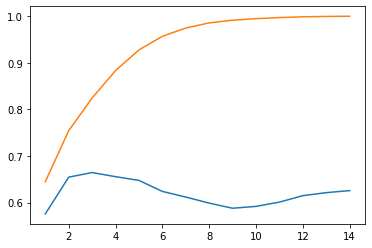

In [44]:
x = range(1,15)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

De acordo com os resultados acima, selecionamos o ```max_depth=3```, que é onde o overfit não afeta nosso modelo.

##RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

O modelo de árvore de decisão é um modelo super simples, poderoso tanto para classificação como para regressão, mas sensível ao overfit.
Outro modelo baseado em árvore que pode ser utilizado é o RandomForest.


In [45]:
from sklearn.ensemble import RandomForestClassifier

teste_lista = []
treino_lista = []
for i in range(1,10):
    modelo_arvore = RandomForestClassifier(max_depth=i)
    teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)    

AUC 0.7754785968683994 - 0.8549995635150238
AUC 0.7868632672744513 - 0.8976687127896622
AUC 0.7931550390103022 - 0.9403124842531797
AUC 0.7983565832578993 - 0.9709123570096604
AUC 0.7990938591103065 - 0.98788117359786
AUC 0.8004527808310704 - 0.9959760554693325
AUC 0.7994808369972844 - 0.9990287365273224
AUC 0.7977776116427432 - 0.9998630161707951
AUC 0.7963008103797579 - 0.9999847540078024


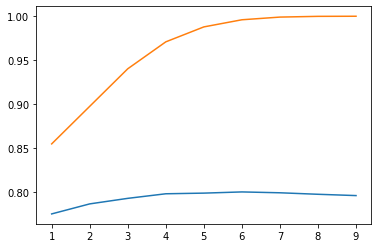

In [46]:
x = range(1,10)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

###parâmetro n_estimators

In [47]:
modelo_arvore = RandomForestClassifier(n_estimators=10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7428159147484805 - 0.999444041300827


In [48]:
modelo_arvore = RandomForestClassifier(n_estimators=100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7939557739557739 - 1.0


In [49]:
modelo_arvore = RandomForestClassifier(n_estimators=200)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7950421219664641 - 1.0


In [50]:
modelo_arvore = RandomForestClassifier(n_estimators=500)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.798442632225527 - 1.0


Após análise podemos utilizar o ```n_estimators=100``` pois a diferença entre 100 e 500 a diferença está na 3ª casa decimal.

##Desafios

###**Desafio 09**
Deixar o gráfico de AUC bonitão.

###**Desafio 10**
Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise. (Dica: Base do titanic).


###**Desafio 11**
Estudar um pouco mais sobre overfit e underfit.

###**Desafio 12**
Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários hiperparâmetros.


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


 GridSearchCV, ele nos permite definir um espaço que queremos explorar, por exemplo:
```
espaco_de_parametros = {
  "max_depth" : [3, 5],
  "min_samples_split" : [32, 64, 128],
  "min_samples_leaf" : [32, 64, 128],
  "criterion" : ["gini", "entropy"]
}
```




###**Desafio 13**
Pesquisar como salvar um modelo treinado.

---

Nesta aula:

* O que é Overfit;
* Como verificar o Overfit;
* Usando o algoritmo de RandomForest.
---
---

#Aula 06 - Finalizando a validação

Nossa base de dados tem muitas colunas (labels) (231), e isso pode facilitar o  overfit.

Mas quais labels podemos remover?

Identificar as colunas com alta correlação.

**NOTA**: Um ponto de atenção é não utilizar a coluna PATIENT_VISIT_IDENTIFIER nos treinamentos dos seus modelos, isso porque essa informação não é relevante para a predição do paciente ir ou não para UTI e manter essa informação no seu x, pode influenciar nos seus resultados.

Vamos gerar a matriz de correlação.


In [51]:
dados_limpos.corr()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,1.000000,-0.017361,0.031159,0.071961,0.058683,0.022828,0.045907,-0.026074,-0.005678,0.021964,0.024226,0.010275,-0.023086,-0.016204,-0.016204,-0.016204,-0.016204,NaN,0.060057,0.060057,0.060057,0.060057,NaN,0.012442,0.012442,0.012442,0.012442,NaN,0.062804,0.062804,0.062804,0.062804,NaN,0.029109,0.029109,0.029109,0.029109,NaN,0.018022,0.018022,...,-0.047713,-0.047713,NaN,0.095052,0.074880,0.076525,0.021779,-0.011847,-0.023686,0.093877,0.069839,0.077927,0.002525,-0.014158,-0.024354,0.096918,0.096265,0.081255,0.043287,0.000536,-0.014310,0.077751,0.057881,0.063673,0.015626,-0.020210,-0.024753,-0.040615,-0.082139,-0.038959,-0.046410,-0.045353,-0.018859,-0.051978,-0.080779,-0.059587,-0.030755,-0.045456,-0.015996,-0.041382
AGE_ABOVE65,-0.017361,1.000000,0.874773,0.031830,0.280326,0.051308,0.165905,0.032608,0.314536,0.003930,0.330744,0.169178,0.137186,-0.111907,-0.111907,-0.111907,-0.111907,NaN,0.069056,0.069056,0.069056,0.069056,NaN,0.097612,0.097612,0.097612,0.097612,NaN,0.018202,0.018202,0.018202,0.018202,NaN,0.054441,0.054441,0.054441,0.054441,NaN,0.021730,0.021730,...,0.071340,0.071340,NaN,-0.146802,0.222891,-0.223129,0.104568,-0.086413,-0.109800,-0.148504,0.220684,-0.207480,0.100707,-0.083182,-0.101247,-0.125120,0.221515,-0.232097,0.101549,-0.093789,-0.100968,-0.138507,0.210206,-0.222678,0.092669,-0.076399,-0.119952,-0.012655,-0.026278,0.012440,-0.005558,0.028262,-0.030515,0.009262,-0.039387,0.002790,-0.021190,0.029317,-0.031404,0.291010
AGE_PERCENTIL,0.031159,0.874773,1.000000,0.056211,0.294671,0.058015,0.134016,0.014480,0.334920,-0.035015,0.324703,0.201001,0.146246,-0.136709,-0.136709,-0.136709,-0.136709,NaN,0.046929,0.046929,0.046929,0.046929,NaN,0.147365,0.147365,0.147365,0.147365,NaN,0.000752,0.000752,0.000752,0.000752,NaN,0.031365,0.031365,0.031365,0.031365,NaN,0.015729,0.015729,...,0.063952,0.063952,NaN,-0.140119,0.269342,-0.201195,0.186620,-0.057003,-0.126255,-0.147229,0.265043,-0.186933,0.182667,-0.055100,-0.120971,-0.115272,0.272013,-0.204079,0.182024,-0.055767,-0.111780,-0.129059,0.249877,-0.208085,0.167176,-0.055859,-0.136280,-0.014140,-0.049698,-0.018826,-0.007992,-0.006030,-0.040314,0.013580,-0.062474,-0.037260,-0.040807,-0.004185,-0.039724,0.351071
GENDER,0.071961,0.031830,0.056211,1.000000,0.036528,-0.001784,-0.064757,-0.069768,-0.019812,-0.020573,-0.013136,-0.026982,0.054201,-0.089776,-0.089776,-0.089776,-0.089776,NaN,-0.018091,-0.018091,-0.018091,-0.018091,NaN,0.018961,0.018961,0.018961,0.018961,NaN,0.039055,0.0390

Mas antes de trabalhar nas correlações, vamos remover as colunas que não nos interessam para a correlação. 

Vamos ver os tipos de nossas colunas.



In [52]:
dados_limpos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


Quais são nossos dados, exceto as do tipo float64.

In [53]:
dados_limpos.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


1. PATIENT_VISIT_IDENTIFIER	= Não faz sentido fazer parte das tabelas
2. AGE_ABOVE65 = Acima de 65 anos. 
3. AGE_PERCENTIL = idade por décadas.
4. GENDER	= Gênero. 
5. WINDOW	= São todas iguais, é a 1ª janela. 
6. ICU = nosso y, o que queremos prever

Vamos remover essas colunas antes da correlação com:
>```dados_limpos.iloc[:,4:-2]```

In [54]:
alta_corr = 0.95
matrix_corr = dados_limpos.iloc[:,4:-2].corr().abs()
excluir = [coluna for coluna in matrix_corr.columns if any(matrix_corr[coluna] > alta_corr)]
len(excluir)

189

In [55]:
matrix_corr

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,0.489245,0.176224,0.153793,0.009174,0.009174,0.009174,0.009174,NaN,0.030413,0.030413,0.030413,0.030413,NaN,0.104179,0.104179,0.104179,0.104179,NaN,0.013215,0.013215,0.013215,0.013215,NaN,0.072771,0.072771,0.072771,0.072771,NaN,0.046671,0.046671,0.046671,0.046671,NaN,0.020510,...,0.005561,0.005561,0.005561,NaN,0.105965,0.112316,0.015686,0.089330,0.035513,0.025573,0.100418,0.110268,0.033409,0.092466,0.033773,0.031653,0.084358,0.124403,0.021311,0.094510,0.024580,0.037813,0.120437,0.099909,0.032427,0.073348,0.042184,0.008804,0.054710,0.053091,0.129220,0.028964,0.041099,0.056287,0.050070,0.054745,0.093512,0.052568,0.039692,0.056984
DISEASE GROUPING 2,0.196347,1.000000,0.084392,0.114818,0.112878,0.032173,0.118516,0.139947,0.068432,0.032245,0.032245,0.032245,0.032245,NaN,0.013532,0.013532,0.013532,0.013532,NaN,0.027544,0.027544,0.027544,0.027544,NaN,0.005880,0.005880,0.005880,0.005880,NaN,0.036119,0.036119,0.036119,0.036119,NaN,0.003539,0.003539,0.003539,0.003539,NaN,0.009126,...,0.048981,0.048981,0.048981,NaN,0.095532,0.031352,0.016813,0.020068,0.011225,0.032448,0.112696,0.024483,0.012664,0.021007,0.012416,0.059772,0.093647,0.026938,0.021756,0.019150,0.005121,0.038081,0.070772,0.041188,0.015483,0.018921,0.016164,0.006302,0.046677,0.029821,0.014222,0.001618,0.024705,0.085122,0.070419,0.016917,0.005102,0.003487,0.024682,0.099019
DISEASE GROUPING 3,0.278271,0.084392,1.000000,0.308875,0.293259,0.275760,0.471039,0.075599,0.141903,0.035719,0.035719,0.035719,0.035719,NaN,0.028061,0.028061,0.028061,0.028061,NaN,0.078813,0.078813,0.078813,0.078813,NaN,0.121935,0.121935,0.121935,0.121935,NaN,0.058743,0.058743,0.058743,0.058743,NaN,0.006233,0.006233,0.006233,0.006233,NaN,0.165258,...,0.009263,0.009263,0.009263,NaN,0.046600,0.144381,0.050511,0.052495,0.095023,0.149534,0.055008,0.141602,0.047499,0.043561,0.093179,0.149762,0.039784,0.136814,0.048458,0.060394,0.093307,0.139419,0.044819,0.150604,0.053770,0.049369,0.088511,0.140484,0.005354,0.027667,0.015035,0.013900,0.000746,0.005011,0.004373,0.020683,0.011633,0.008895,0.003183,0.006110
DISEASE GROUPING 4,0.017529,0.114818,0.308875,1.000000,0.128287,0.171438,0.136472,0.103100,0.063919,0.049593,0.049593,0.049593,0.049593,NaN,0.012640,0.012640,0.012640,0.012640,NaN,0.051789,0.051789,0.051789,0.051789,NaN,0.005492,0.005492,0.005492,0.005492,NaN,0.072546,0.072546,0.072546,0.072546,NaN,0.028718,0.028718,0.028718,0.028718,NaN,0.008524,...,0.033033,0.0

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.where.html

In [56]:
matrix_corr.shape

(225, 225)

In [57]:
np.ones(matrix_corr.shape).astype(np.bool)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

https://numpy.org/doc/stable/reference/generated/numpy.triu.html (Upper triangle of an array.)

https://numpy.org/doc/stable/reference/generated/numpy.tril.html (Lower triangle of an array.)







In [58]:
# k=1, zera a diagonal principal
np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [59]:
matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)]


len(excluir)

131

In [60]:
def remove_corr_var(dados, valor_corte):

    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]

    return dados.drop(excluir, axis=1)

In [61]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos, 0.95)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

In [62]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.798442632225527 - 1.0


(0.798442632225527, 1.0)

In [63]:
roda_modelo_cv(modelo_arvore, dados_limpos_sem_corr, 5, 10)

AUC 0.8091057265399371 - 1.0


(0.8091057265399371, 1.0)

* Dica 1 - Quando for salvar o modelo final, treine com todos os dados que tem.
 
* Dica 2 - Na hora de salvar o modelo tem que transformar os dados. (pipeline?)

##Desafios

###**Desafio 14**
Ler no Sklearn sobre feature selection, feature importance.

###**Desafio 15**
Plotar também a matriz de confusão.

###**Desafio 16**
Repassar pelo desafio 12, com as bases de dados alteradas.

###**Desafio Extra**
Criar um pipeline de treinamento.

https://scikit-learn.org/stable/modules/compose.html#pipeline




---

Nesta aula:

* Gerar uma matriz de correlação dos dados;
* Avaliar a importação dos atributos no resultado final;
* Desenvolver uma função para remover dados correlacionados.---
---
---